In [1]:
from hypersurface import *
import sympy as sp
from pprint import pprint
from scipy.optimize import minimize
from sympy.utilities.iterables import flatten
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
z0, z1, z2, z3, z4= sp.symbols('z0, z1, z2, z3, z4')
Z = [z0,z1,z2,z3,z4]
f = z0**5 + z1**5 + z2**5 + z3**5 + z4**5 + 0.5*z0*z1*z2*z3*z4
HS = Hypersurface(Z, f, 1000)

In [3]:
k = 2
HS.set_k(k)

Normalization factor of eta

In [4]:
# holomorphic=True by default
factor = (HS.integrate(lambda patch, point: patch.omega_omegabar(point), numerical=True) / \
          HS.integrate(lambda patch, point: patch.num_FS_volume_form('identity', point), numerical=True))

In [5]:
def get_h_diag(HS, k):
    # Get the power of the coordiantes
    sec, ns = HS.get_sections(k)
    h_diag = []
    for expr in sec:
        power = []
        for i in range(len(Z)):
            power.append(expr.diff(Z[i])*Z[i]/expr)
        h_diag.append(power)

    # Permutate and compare the coordinates
    param = 1
    for i in range(len(h_diag)):
        if not isinstance(h_diag[i], list):
            continue
        power = sorted(h_diag[i])
        for j in range(i, len(h_diag)):
            if not isinstance(h_diag[j], list):
                continue
            if sorted(h_diag[j]) == power:
                h_diag[j] = param
        param += 1

    return h_diag

In [6]:
h_sym = get_h_diag(HS, k)

Reconstruct h matrix from the parameters

In [7]:
def param_to_matrix(param):
    h_diag = h_sym.copy()
    for i in range(len(param)):
        for j in range(len(h_diag)):
            if h_sym[j] == i+2:
                h_diag[j] = param[i]
    h = np.diag(h_diag)  
    return h

In [8]:
def integration(param): 
    h = param_to_matrix(param)
    #h = np.matmul(g, np.conj(g.transpose()))
    integration = HS.patches[0].integrate(lambda patch, point, h_matrix=h: 
                                np.absolute(patch.num_eta(h_matrix, point)*factor - 1).real, 
                                holomorphic=False, numerical=True)
    integration = integration.real
    print(integration)
    print(param)
    try:
        np.linalg.cholesky(h)
    except:
        print("Not positive definite")
    return integration

Set an initial condition

In [9]:
g0 = 3*np.ones(max(h_sym) - 1)

In [10]:
#res = minimize(integration, g0, method='L-BFGS-B', options={'iprint':1, 'ftol': 1e-04, 'eps': 1e-02, 'maxiter':20})
res = minimize(integration, g0, method='L-BFGS-B', options={'ftol': 1e-06, 'maxiter':200})

0.9096518472504083
[3.]
0.9096518486238941
[3.00000001]
0.7349896168761934
[2.]
0.7349896190897798
[2.00000001]
1.896557865119289
[-2.]
Not positive definite
1.8965576726379914
[-1.99999999]
Not positive definite
0.36970621653317115
[0.25887843]
0.3697062073442662
[0.25887844]
0.6530910875687687
[1.6619929]
0.6530910902347267
[1.66199291]
0.279596687299149
[0.62421056]
0.27959669121057795
[0.62421057]
0.25131801833776
[0.50890692]
0.25131801885762173
[0.50890693]
123538517.83248468
[-1.00818216]
Not positive definite
123540832.14466809
[-1.00818215]
Not positive definite
0.2513180183377512
[0.50890692]
0.2513180188576129
[0.50890693]
0.2513180183377425
[0.50890692]
0.2513180188576041
[0.50890693]
1.819923943103013
[-0.24963762]
Not positive definite
1.8199238547922731
[-0.24963761]
Not positive definite
0.2917417277315072
[0.36304567]
0.2917417219397657
[0.36304568]
0.2509943018490581
[0.49817322]
0.25099430198030137
[0.49817323]
0.2509828056664023
[0.49454826]
0.2509828055989312
[0.49

In [11]:
h_minimal = param_to_matrix(res.x)

In [12]:
print(h_minimal)

[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.49551714 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.49551714 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.49551714 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.49551714 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.

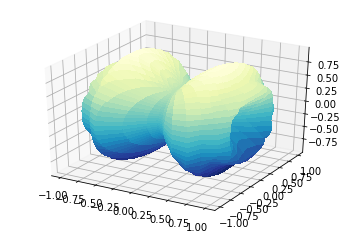

In [13]:
#param = [0.5, 0.5, 0.5, 0.5]
#h_minimal = param_to_matrix(param)
patch = HS.patches[0].patches[0]
theta, phi = np.linspace(0.001,np.pi+0.001, 40), np.linspace(0.001, 2*np.pi+0.001, 40)
R = []
for j in phi:
    theta_list = []
    for i in theta:
        t = complex(math.sin(i)*math.sin(j), math.cos(i))/(sin(i)*cos(j)) 
        if np.absolute(t) <= 1:
            eta = patch.num_eta(h_minimal, [1, -1, complex(t), 0, -complex(t)])*factor
        else:
            eta = patch.num_eta(h_minimal, [1, -1, complex(1/t), 0, -complex(1/t)])*factor
        theta_list.append(float(eta))
    R.append(theta_list)
R = np.asarray(R)
THETA, PHI = np.meshgrid(theta, phi)
X = R * np.sin(THETA) * np.cos(PHI)
Y = R * np.sin(THETA) * np.sin(PHI)
ZZ = R * np.cos(THETA)
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
plot = ax.plot_surface(
    X, Y, ZZ, rstride=1, cstride=1, cmap=plt.cm.YlGnBu_r,
    linewidth=0, antialiased=False)

Standard deviation of eta:

In [18]:
sum_eta = 0
for patch in HS.patches:
    for subpatch in patch.patches:
        for point in subpatch.points:
            #print(subpatch.num_eta(h_minimal, point)*factor - 1)
            sum_eta += (subpatch.num_eta(h_minimal, point)*factor - 1)**2
print(math.sqrt(sum_eta/(HS.n_points - 1)))

0.3530462716612851
